In [21]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib as mpl
import torch
import numpy as np
import imageio
import matplotlib.image as mpimg
import matplotlib.animation as animation

# remove top and right axis from plots
# mpl.rcParams["axes.spines.right"] = False
# mpl.rcParams["axes.spines.top"] = False

# remove all edges
# mpl.rcParams["axes.edgecolor"] = "none"

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

import os
# the log path
log_dir = Path('../src/train/logs/train_L0_rnn_npe/a0')

In [2]:
def get_log_probs(event_path):
    event_acc = EventAccumulator(str(event_path))
    event_acc.Reload()
    # print(event_acc.Tags()) # Show all tags in the log file

    _, step_nums, training_log_probs = zip(*event_acc.Scalars('training_log_probs'))
    _, _, validation_log_probs = zip(*event_acc.Scalars('validation_log_probs'))
    _, _, best_validation_log_prob = zip(*event_acc.Scalars('best_validation_log_prob'))
    return step_nums, training_log_probs, validation_log_probs, best_validation_log_prob

In [ ]:
event_path = Path('./src/train/logs/train_L0_rnn') / 'events.out.tfevents.1681763284.snnmonster.195783.0'
# step_nums, training_log_probs, validation_log_probs, best_validation_log_prob = get_log_probs(event_path)
# best_validation_log_prob = max(training_log_probs)

# fig, ax = plt.subplots(figsize=(10,5))
# plt.plot(step_nums, training_log_probs, '.-', label='train_log_probs')
# plt.plot(step_nums, validation_log_probs, '.-', label='valid_log_probs')
# plt.plot(best_epochs, best_valid_log_prob, 'v', label='with best valid_log_prob', markersize=10)
# plt.plot(best_epochs, best_train_log_prob, 'v', markersize=10)
# plt.legend()
# plt.xlabel('epochs')
# plt.ylabel('log_probs')
# plt.grid(alpha=0.2)
# # plt.ylim([-1, 0.3])
# # plt.title(title)

In [3]:
!pwd
!ls ../src/train/logs

/home/wehe/tmp/NSC/codes/notebook
log-test  logs_L0_v1   train_L0_rnn	 train_L0_rnn_npe_parallel
log_test  logs_L0_v1_  train_L0_rnn_npe


## example of data

training input data x has a shape of 
torch.Size([5000, 4200, 16])

Showing two of the x (partial):
of shape torch.Size([50, 16])


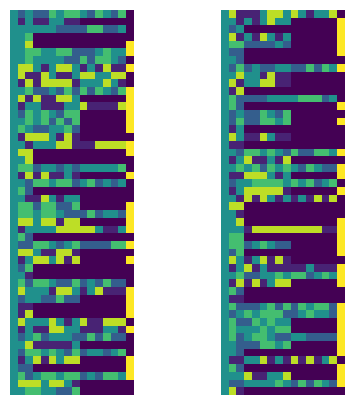

In [4]:
x_data_path = log_dir / 'training_dataset/x_round0_run2.pt'
x = torch.load(x_data_path)
print(f'training input data x has a shape of \n{x.shape}')

fig,axes = plt.subplots(1, 2, figsize=(5, 5))
ax = axes[0]
ax.imshow(x[0, :50, :].numpy())
ax.axis('off')
ax = axes[1]
ax.imshow(x[1, :50, :].numpy())
ax.axis('off')
print(f'\nShowing two of the x (partial):\nof shape {x[0, :50, :].shape}')

## training curve

In [5]:
# parse data from event file

# print the files in the log path
for root, dirs, files in os.walk(log_dir):
    for name in files:
        if name.startswith('events.out.tfevents'):
            event_path = os.path.join(root, name)
print('event file path:')
print(event_path)

event_acc = EventAccumulator(str(event_path))
event_acc.Reload()
# print(event_acc.Tags()) # Show all tags in the log file
_, step_nums, training_log_probs = zip(*event_acc.Scalars('training_log_probs'))


event file path:
../src/train/logs/train_L0_rnn_npe/a0/events.out.tfevents.1681681787.snnmonster.130398.0


In [6]:
# parse data from log file
training_log_dir = '../cluster/snn/train_L0_rnn_npe/output_logs/a0.log'
lines = []
with open(training_log_dir, 'r') as f:
    lines.extend(line for line in f if line.startswith(" Epochs trained:"))
epochs = [line.split(" ||  ")[0] for line in lines]
epochs = [epoch.split(":")[1] for epoch in epochs]
step_nums = np.array([float(epoch.split(" Time")[0]) for epoch in epochs])
log_probs = [line.split(" ||  ")[1] for line in lines]
log_probs = [log_prob.split(":") for log_prob in log_probs]
training_log_probs = [float(log_prob[1].split(' val')[0]) for log_prob in log_probs]
validation_log_probs = [float(log_prob[2]) for log_prob in log_probs]

# best validation epoch
lines = []
with open(training_log_dir, 'r') as f:
    lines.extend(line for line in f if line.startswith("        Best validation performance:"))
    
best_epochs = [int(float(line.split(', from epoch ')[1])) for line in lines]

best_train_log_prob = [training_log_probs[best_epoch-1] for best_epoch in best_epochs]
best_valid_log_prob = [validation_log_probs[best_epoch-1] for best_epoch in best_epochs]

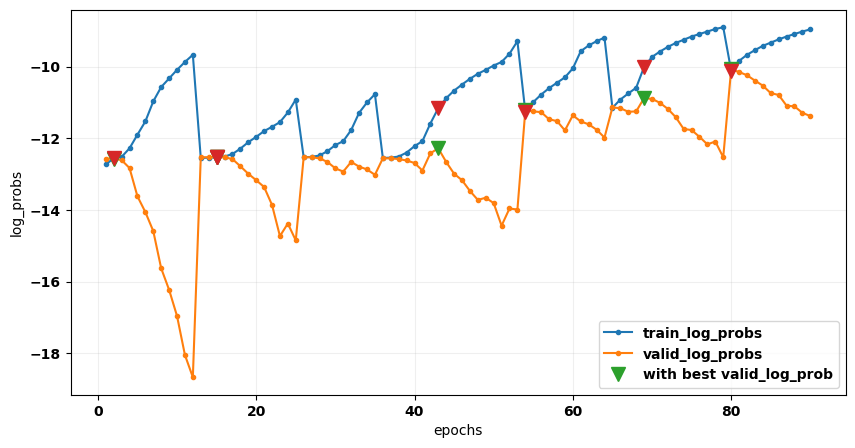

In [160]:
# step_nums, training_log_probs, validation_log_probs, best_validation_log_prob = get_log_probs(event_path)
# best_validation_log_prob = max(training_log_probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(step_nums, training_log_probs, '.-', label='train_log_probs')
plt.plot(step_nums, validation_log_probs, '.-', label='valid_log_probs')
plt.plot(best_epochs, best_valid_log_prob, 'v', label='with best valid_log_prob', markersize=10)
plt.plot(best_epochs, best_train_log_prob, 'v', markersize=10)
plt.legend()
plt.xlabel('epochs')
plt.ylabel('log_probs')
plt.grid(alpha=0.2)
# plt.ylim([-1, 0.3])
# plt.title(title)

## problem: memory usage

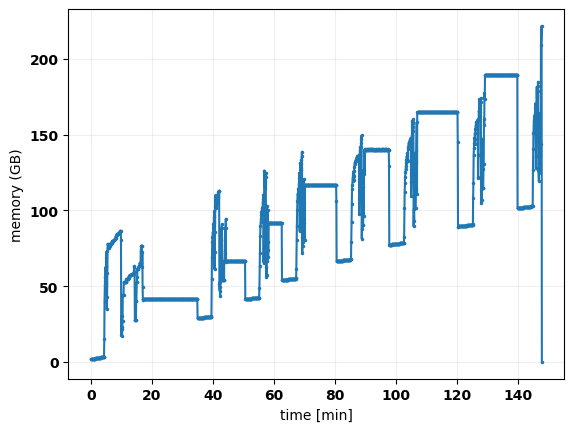

In [35]:
resource_usage_dir = log_dir / 'resource_usage.log'
# load log file
with open(resource_usage_dir, 'r') as f:
    lines = f.readlines()
# get the memory usage
memory_usage = [float(line.split('|')[:][1][5:-4]) for line in lines[1:]]
memory_usage_GPU = [float(line.split('|')[:][2].split('-')[1][1:-16])/1024 for line in lines[1:]]
time_min = [float(line.split('|')[:][0][:-5]) for line in lines[1:]]
plt.figure()
plt.plot(time_min, memory_usage, '.-', label='CPU', markersize=3)
# plt.plot(time_min, memory_usage_GPU, '-', label='GPU')
plt.ylabel('memory (GB)')
plt.xlabel('time [min]')
plt.grid(alpha=0.2)

5: start processing sampling shuffle requires **huge** memory</br>

    - shuffle data
    - high dimensional data -> low dimensional data

10: start appending to simulation</br>

20: start training</br>

## check the posterior after each run training 

results shown in the presentation

In [158]:
def check_post_results(x_figures, x_figures_run_idx, x_valid_id, shuffled=False):
    images = []
    print('animating posterior results')
    for idx, (filename, run_idx) in enumerate(zip(*(x_figures, x_figures_run_idx))):
    
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        ax = axes#[0]
        img = mpimg.imread(log_dir/'posterior'/filename)
        print(filename)
        ax.imshow(img)
        ax.axis('off')
        if shuffled:
            ax.set_title(f'validate x_shuffled_{x_valid_id} run {run_idx} \n(model from epoch: {best_epochs[run_idx]})')
        if not shuffled:
            ax.set_title(f'validate x_{x_valid_id} run {run_idx} \n(model from epoch: {best_epochs[run_idx]})')
        if x_valid_id == 6:
            ax.set_title(f'validate x_o run {run_idx} \n(model from epoch: {best_epochs[run_idx]})')

        # ax = axes[1]
        # ax.plot(step_nums, training_log_probs, '.-', label='train_log_probs')
        # ax.plot(step_nums, validation_log_probs, '.-', label='valid_log_probs')
        # ax.plot(best_epochs[run_idx], best_valid_log_prob[run_idx], 'v', label='with best valid_log_prob', markersize=10)
        # ax.plot(best_epochs[run_idx], best_train_log_prob[run_idx], 'v', markersize=10)
        # ax.legend()
        # ax.set_xlabel('epochs')
        # ax.set_ylabel('log_probs')
        # ax.grid(alpha=0.2)

        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        plt.close(fig)
    
    return images

def animate_posterior_results(x_valid_id, shuffled=False):

    x_figures_all = os.listdir(log_dir/'posterior')

    if not shuffled:
        # find element starting with post_plot_x_val_0 
        x_figures = [figure for figure in x_figures_all if figure.startswith(f'post_plot_x_val_{x_valid_id}')]
        x_figures.sort(key=lambda x: int(x.split('_run')[-1].split('.')[0]))
        x_figures_run_idx = [int(figure.split('_run')[-1].split('.')[0]) for figure in x_figures]

    if shuffled:
        # find element starting with post_plot_x_val_0 
        x_figures = [figure for figure in x_figures_all if figure.startswith(f'post_plot_x_val_shuffled_{x_valid_id}')]
        x_figures.sort(key=lambda x: int(x.split('_run')[-1].split('.')[0]))
        x_figures_run_idx = [int(figure.split('_run')[-1].split('.')[0]) for figure in x_figures]

    if x_valid_id == 6: # check x_o
        x_figures = [figure for figure in x_figures_all if figure.startswith(f'post_plot_x_o')]
        x_figures.sort(key=lambda x: int(x.split('_run')[-1].split('.')[0]))
        x_figures_run_idx = [int(figure.split('_run')[-1].split('.')[0]) for figure in x_figures]

    # show a animation by stacking the figures
    images = check_post_results(x_figures, x_figures_run_idx, x_valid_id, shuffled)

    # save the movie
    if x_valid_id != 6:
        if shuffled:
            imageio.mimsave(log_dir/'posterior'/'ani'/f'posterior_x_shuffled_{x_valid_id}.gif', images, fps=1)
        else:
            imageio.mimsave(log_dir/'posterior'/'ani'/f'posterior_x_{x_valid_id}.gif', images, fps=1)
    else:
        imageio.mimsave(log_dir/'posterior'/'ani'/f'posterior_x_o.gif', images, fps=1)

    print('saved animation')
    if x_valid_id != 6:
        if shuffled:
            filename=log_dir/'posterior'/'ani'/f'posterior_x_shuffled_{x_valid_id}.gif'
        else:
            filename=log_dir/'posterior'/'ani'/f'posterior_x_{x_valid_id}.gif'
    else:
        filename = log_dir/'posterior'/'ani'/f'posterior_x_o.gif'
    
    print(filename)
    return filename

animating posterior results
post_plot_x_val_shuffled_0_round0_run0.png
post_plot_x_val_shuffled_0_round0_run1.png
post_plot_x_val_shuffled_0_round0_run2.png
post_plot_x_val_shuffled_0_round0_run3.png
post_plot_x_val_shuffled_0_round0_run4.png
post_plot_x_val_shuffled_0_round0_run5.png
post_plot_x_val_shuffled_0_round0_run6.png
saved animation
../src/train/logs/train_L0_rnn_npe/a0/posterior/ani/posterior_x_shuffled_0.gif
animating posterior results
post_plot_x_val_0_round0_run0.png
post_plot_x_val_0_round0_run1.png
post_plot_x_val_0_round0_run2.png
post_plot_x_val_0_round0_run3.png
post_plot_x_val_0_round0_run4.png
post_plot_x_val_0_round0_run5.png
post_plot_x_val_0_round0_run6.png
saved animation
../src/train/logs/train_L0_rnn_npe/a0/posterior/ani/posterior_x_0.gif
animating posterior results
post_plot_x_val_shuffled_1_round0_run1.png
post_plot_x_val_shuffled_1_round0_run2.png
post_plot_x_val_shuffled_1_round0_run3.png
post_plot_x_val_shuffled_1_round0_run4.png
post_plot_x_val_shuffled

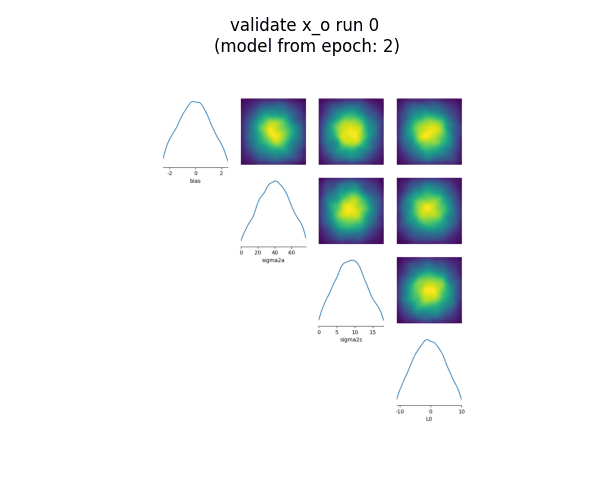

In [159]:
# make dir
os.makedirs(log_dir/'posterior'/'ani', exist_ok=True)

for x_valid_id in range(7):
    filename = animate_posterior_results(x_valid_id, shuffled=True)
    filename = animate_posterior_results(x_valid_id, shuffled=False)

from IPython.display import Image
Image(filename)

In [50]:
# generate a mp4 file
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

def update(frame):
    ax = axes[0]
    ax.clear()
    img = mpimg.imread(log_dir/'posterior'/x_0_figures[frame])
    ax.imshow(img)
    ax.axis('off')

    ax = axes[1]
    ax.clear()
    ax.plot(step_nums, training_log_probs, '.-', label='train_log_probs')
    ax.plot(step_nums, validation_log_probs, '.-', label='valid_log_probs')
    ax.plot(best_epochs[frame], best_valid_log_prob[frame], 'v', label='with best valid_log_prob', markersize=10)
    ax.plot(best_epochs[frame], best_train_log_prob[frame], 'v', markersize=10)
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('log_probs')
    ax.grid(alpha=0.2)

    # fig.canvas.draw()       # draw the canvas, cache the renderer
    # image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    # image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    # images.append(image)
    plt.close(fig)
from matplotlib import animation

ani = animation.FuncAnimation(fig, update, frames=len(x_0_figures), interval=1000)
# ani = animation.FuncAnimation(fig, update, frames=30, interval=5)
ani.save(log_dir/'posterior'/'posterior_x_0.mp4', fps=50)  

from IPython.display import HTML
HTML(ani.to_html5_video())

## plot x_o

In [50]:
import sys
sys.path.append('../src')
import os
os.chdir('../')

In [51]:
from dataset.get_xo import get_xo
from config.load_config import load_config
config = load_config(
    config_simulator_path=Path('./src/config') / 'test' / 'test_simulator.yaml',
    config_dataset_path=Path('./src/config') / 'test' / 'test_dataset.yaml',
    config_train_path=Path('./src/config') / 'test' / 'test_train.yaml',
)

ModuleNotFoundError: No module named 'dataset'

In [52]:
x_o = get_xo(
        subject_id          = config['x_o']['subject_id'],
        chosen_dur_list     = config['x_o']['chosen_dur_list'],
        chosen_MS_list      = config['x_o']['chosen_MS_list'],
        seqC_sample_per_MS     = config['x_o']['seqC_sample_per_MS'],
        trial_data_path     = config['x_o']['trial_data_path'],
        
        seqC_process_method = config['dataset']['seqC_process'],
        nan2num             = config['dataset']['nan2num'],
        summary_type        = config['dataset']['summary_type'],
    )


NameError: name 'get_xo' is not defined

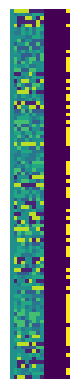

In [82]:
for i in range(21):
    img = plt.imshow(x_o[i*100:(i+1)*100,:])
    plt.axis('off')
    plt.savefig(f'./src/train/logs/train_L0_rnn/a0/x_o/x_o_{i}.png', bbox_inches='tight', pad_inches=0)

## TODO

- memory usage of processing sampling shuffle is *huge*
    - subset processing
    - using collate_fn during training
- using summary feature as input